In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import AllTogether as t
import seaborn as sns
import math

import IPython as display
%matplotlib inline

In [3]:
df = pd.read_csv("house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# this is to check if there is a raw with price columns NaN
list(df.columns)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [13]:
# what is the range of house pricing for medium houses

# First we have to identify the aspects related to house size , 'bedrooms','bathrooms','sqft_living','sqft_lot'

price_mid_hs = df[['price','bedrooms','bathrooms','sqft_living15','sqft_lot15','grade']]
# print(price_mid_hs.shape)

#now we have all house sizing aspects in standalone DataFrame, we can the medium of the messurement and compare it with size. First drop all prices that are above the mean.

# 1. Count the Price mean
Price_mean = price_mid_hs.price.mean()
# print(Price_mean)

# 2. remove any raw that hold any price larger than the mean
md_price_mid_hs = price_mid_hs[price_mid_hs.price < Price_mean]
# print(md_price_mid_hs.shape)

new_Price_mean  = math.floor(md_price_mid_hs.price.mean())
# print(new_Price_mean)

# 3. Count all mediums of all house size aspect
new_bedrooms_mean = math.floor(md_price_mid_hs.bedrooms.mean())
new_bathrooms_mean = math.floor(md_price_mid_hs.bathrooms.mean())
new_sqft_living_mean = math.floor(md_price_mid_hs.sqft_living15.mean())
new_sqft_lot_mean = math.floor(md_price_mid_hs.sqft_lot15.mean())
new_grade_mean = math.floor(md_price_mid_hs.grade.mean())

# 4. print the result of the conclusion
# print(f"the expected aspects of the house size for this range of price slitly more or less than {new_Price_mean}$, as follow, Bedrooms: {new_bedrooms_mean}, Bathrooms: {new_bathrooms_mean}, sqft_living: {new_sqft_living_mean}, sqft_lot: {new_sqft_lot_mean}, and the approximite grade is {new_grade_mean}")
#price_mid_hs[price_mid_hs.bedrooms.mean() > 0.5]
#price_mid_hs.bedrooms.mean().sum(axis = 0)

result = pd.DataFrame({'Average Price':new_Price_mean,'Expected number of bedrooms':new_bedrooms_mean,'Expected number of bathrooms':new_bathrooms_mean,'Expected size of living area':new_sqft_living_mean,'Expected building size':new_sqft_lot_mean,'Expected grade':new_grade_mean}, index=[' '])
result


,Average Price,Expected number of bedrooms,Expected number of bathrooms,Expected size of living area,Expected building size,Expected grade
,355475,3,1,1721,11065,7


In [15]:
predic_price = df[['price','bedrooms','bathrooms','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15']]
predic_price.shape

(21613, 17)

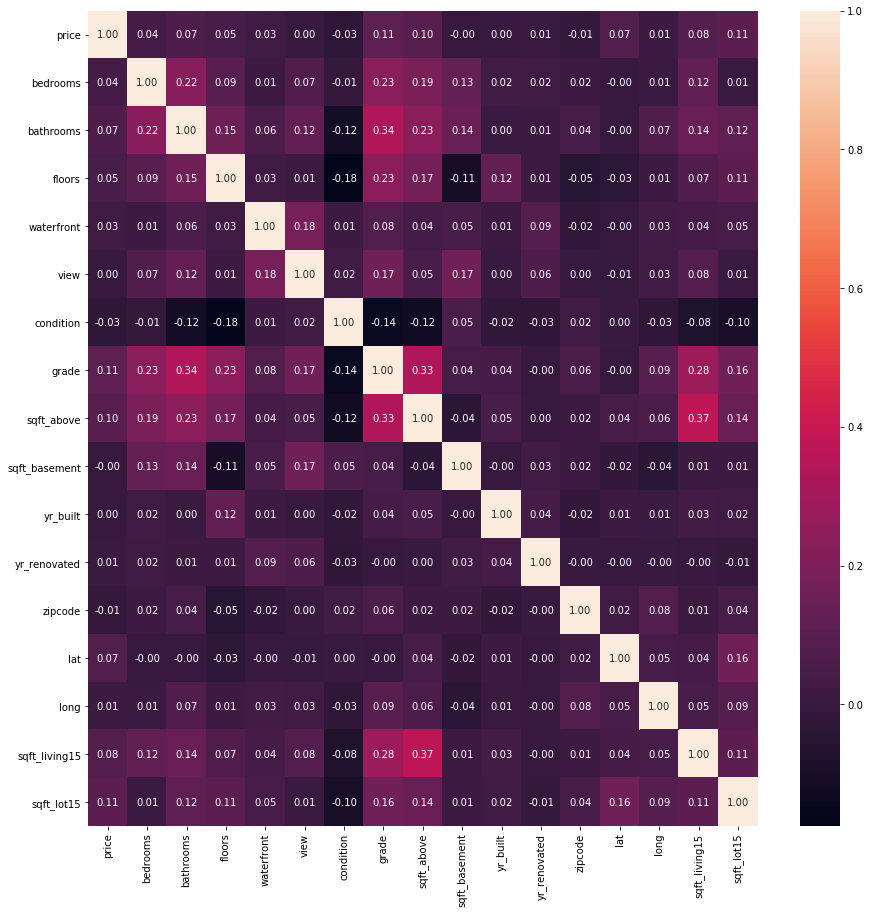

In [17]:
plt.figure(figsize=(15, 15))
corr = predic_price.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr,annot=True, fmt=".2f")

In [18]:
corr_target = abs(corr["price"])
#Selecting highly correlated features
relevant_features = corr_target[corr_target>0.10]
relevant_features

price         1.000000
grade         0.109556
sqft_lot15    0.108943
Name: price, dtype: float64

In [20]:
def clean_data(df):
    
    df = df.dropna(subset=['price'], axis=0)
    y = df['price']
    
    #Drop respondent and expected salary columns
    df = df.drop(['price'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(predic_price) 


In [23]:
x2n, x2t, y2n, y2t = train_test_split(X, y, test_size = 0.3, random_state = 42)

lm2_model = LinearRegression(normalize=True)
lm2_model.fit(x2n,y2n)

y_test_preds = lm2_model.predict(x2t) 

rsquared_score = r2_score(y2t, y_test_preds) 
length_y_test = len(y2t)


"The r-squared score for the model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.6992608992215116 on 6484 values.'